In [2]:
import re
import pandas as pd
import json
from datetime import datetime
import numpy as np

# 读取 SQL 文件
with open('./data/meal_list.sql', 'r', encoding='utf-8') as f:
    sql_content = f.read()

# 提取插入语句中的数据
insert_statements = re.findall(r"INSERT INTO `meal_list` VALUES \((.*?)\);", sql_content, re.S)

# 解析数据
meal_data = []
for statement in insert_statements:
    rows = statement.split("),(")
    for row in rows:
        row_data = row.split(',')
        meal_data.append([int(row_data[0]), row_data[1].strip("'"), row_data[2].strip("'")])

# 创建 DataFrame
meal_df = pd.DataFrame(meal_data, columns=['mealno', 'mealID', 'meal_name'])

# 读取 JSON 文件
with open('./data/MealRatings_201705_201706.json', 'r', encoding='utf-8') as f:
    ratings_data = json.load(f)

# 创建 DataFrame
ratings_df = pd.DataFrame(ratings_data)

# 数据预处理
# 1. 原始数据的探索分析
total_records = len(ratings_df)
total_users = ratings_df['UserID'].nunique()
total_meals = ratings_df['MealID'].nunique()
max_rating = ratings_df['Rating'].max()
min_rating = ratings_df['Rating'].min()

print(
    f"总纪录数: {total_records}, 总用户数: {total_users}, 总菜品数: {total_meals}, 最高评分: {max_rating}, 最低评分: {min_rating}"
)

# 评分分布统计
rating_distribution = ratings_df['Rating'].value_counts(normalize=True)
print("评分分布:")
print(rating_distribution)

# 检查重复评分记录
duplicated_ratings = ratings_df[ratings_df.duplicated(subset=['UserID', 'MealID'], keep=False)]
num_duplicated = len(duplicated_ratings)
print(f"重复评分记录总数: {num_duplicated}")

# 处理重复评分记录
ratings_df.sort_values(
    by=['UserID', 'MealID', 'ReviewTime'], ascending=[True, True, False], inplace=True
)
ratings_df.drop_duplicates(subset=['UserID', 'MealID'], keep='first', inplace=True)

# 更新后的总记录数
total_records_after_dedup = len(ratings_df)
print(f"去重后的记录总数: {total_records_after_dedup}")

# 数据变换
# 编码用户和菜品
user_id_map = {user_id: idx for idx, user_id in enumerate(ratings_df['UserID'].unique())}
meal_id_map = {meal_id: idx for idx, meal_id in enumerate(ratings_df['MealID'].unique())}

ratings_df['user_code'] = ratings_df['UserID'].map(user_id_map)
ratings_df['meal_code'] = ratings_df['MealID'].map(meal_id_map)

总纪录数: 38384, 总用户数: 5130, 总菜品数: 1685, 最高评分: 5.0, 最低评分: 1.0
评分分布:
Rating
5.0    0.547754
4.0    0.238172
3.0    0.116585
2.0    0.051063
1.0    0.046426
Name: proportion, dtype: float64
重复评分记录总数: 2518
去重后的记录总数: 37125


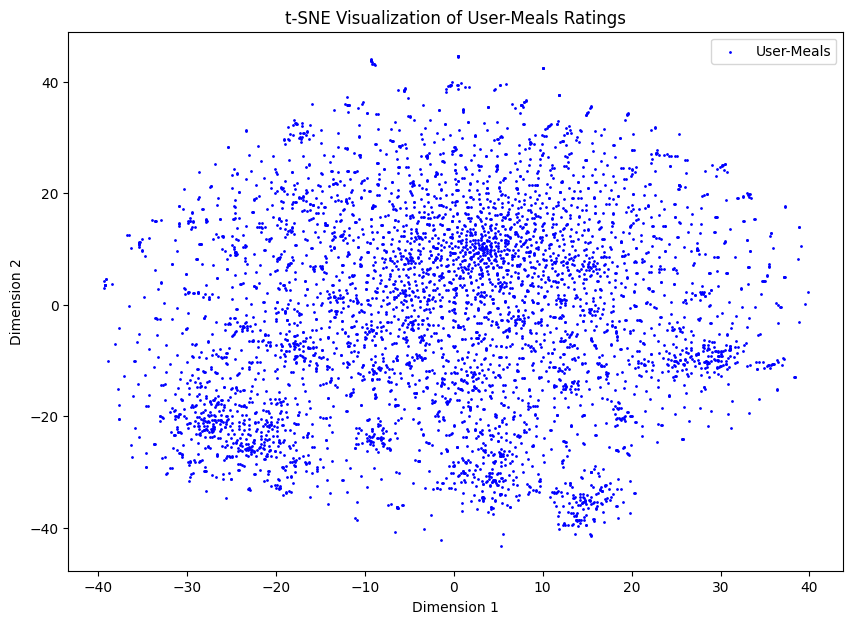

In [3]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# 获取用户数和菜品数
n_users = ratings_df['user_code'].nunique()
n_meals = ratings_df['meal_code'].nunique()

# 创建用户-菜品评价矩阵
rating_matrix = np.full((n_users, n_meals), -1, dtype=float)

for row in ratings_df.itertuples():
    rating_matrix[row.user_code, row.meal_code] = row.Rating


# t-SNE降维
tsne = TSNE(n_components=2, random_state=480)
tsne_results = tsne.fit_transform(rating_matrix)

# 可视化
plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=1, c='blue', label='User-Meals')
plt.title('t-SNE Visualization of User-Meals Ratings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


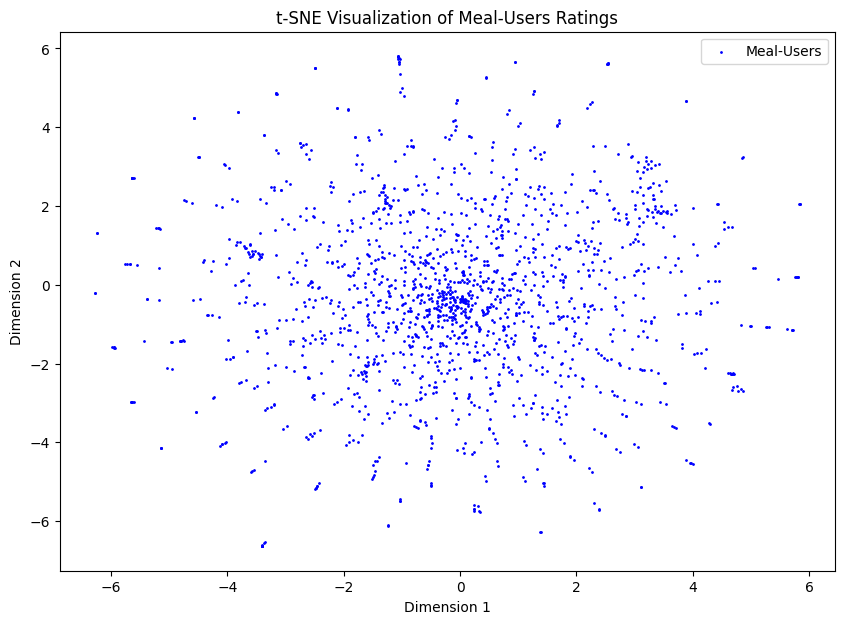

In [4]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# 获取用户数和菜品数
n_users = ratings_df['user_code'].nunique()
n_meals = ratings_df['meal_code'].nunique()

# 创建用户-菜品评价矩阵
rating_matrix = np.full((n_users, n_meals), -1, dtype=float)

for row in ratings_df.itertuples():
    rating_matrix[row.user_code, row.meal_code] = row.Rating


# t-SNE降维
tsne = TSNE(n_components=2, random_state=480)
tsne_results = tsne.fit_transform(rating_matrix.T)

# 可视化
plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=1, c='blue', label='Meal-Users')
plt.title('t-SNE Visualization of Meal-Users Ratings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


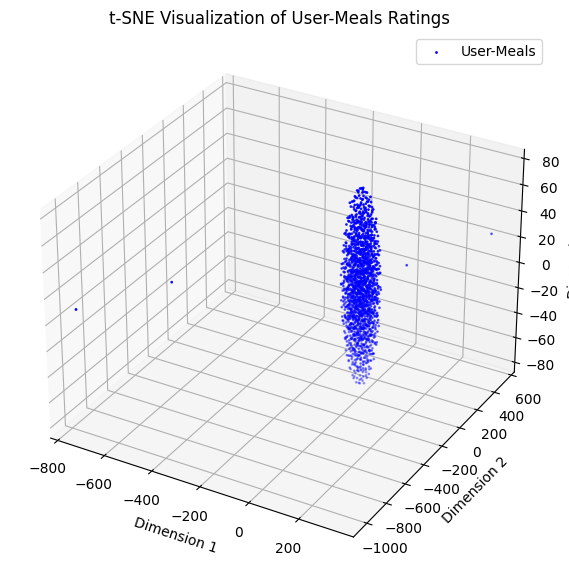

In [3]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 获取用户数和菜品数
n_users = ratings_df['user_code'].nunique()
n_meals = ratings_df['meal_code'].nunique()

# 创建用户-菜品评价矩阵
rating_matrix = np.full((n_users, n_meals), -1, dtype=float)

for row in ratings_df.itertuples():
    rating_matrix[row.user_code, row.meal_code] = row.Rating

# t-SNE降维
tsne = TSNE(n_components=3, random_state=42)
tsne_results = tsne.fit_transform(rating_matrix.T)

# 可视化
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], s=1, c='blue', label='User-Meals'
)
ax.set_title('t-SNE Visualization of User-Meals Ratings')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()

In [5]:
# t-SNE降维
tsne = TSNE(n_components=2, random_state=64)
tsne_results = tsne.fit_transform(rating_matrix.T)

# 可视化
plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=1, c='blue', label='MealsUser')
plt.title('t-SNE Visualization of User-Meals Ratings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()